<a href="https://colab.research.google.com/github/anuragiiser/Multi_Modal_IR/blob/main/CLIP_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
import open_clip
import os

In [ ]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='datacomp_xl_s13b_b90k')

open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7a28ad4a0160>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
from open_clip import tokenizer
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

Feeding example images and their textual descriptions to the model

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
!unzip image_captioning.zip

Archive:  image_captioning.zip
  inflating: image_captioning/basket_of_fruits.png  
  inflating: image_captioning/cup_of_coffee.png  
  inflating: image_captioning/fox_eating.png  
  inflating: image_captioning/kids_jumping.png  
  inflating: image_captioning/lion_chasing_buffallo.png  
  inflating: image_captioning/small_boy_on_cycle.png  
  inflating: image_captioning/turtle.png  
  inflating: image_captioning/woman_jogging.png  


In [ ]:
%matplotlib inline
# images in skimage to use and their textual descriptions
"""descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}"""
descriptions = {
    "cup_of_coffee": "a cup of coffee",
    "woman_jogging": "a lady jogging on the road",
    "lion_chasing_buffallo": "a lion chasing a buffalo",
    "turtle": "a turtle beside seashore",
    "small_boy_on_cycle": "small boy on cycle",
    "basket_of_fruits": "a basket of fruits",
    "fox_eating": "a fox eating its prey",
    "kids_jumping": "kids jumping"
}

Download dataset from here
https://drive.google.com/file/d/14sSUP9jDRcYaadiTp4fXf-62vj2biPwf/view?usp=sharing

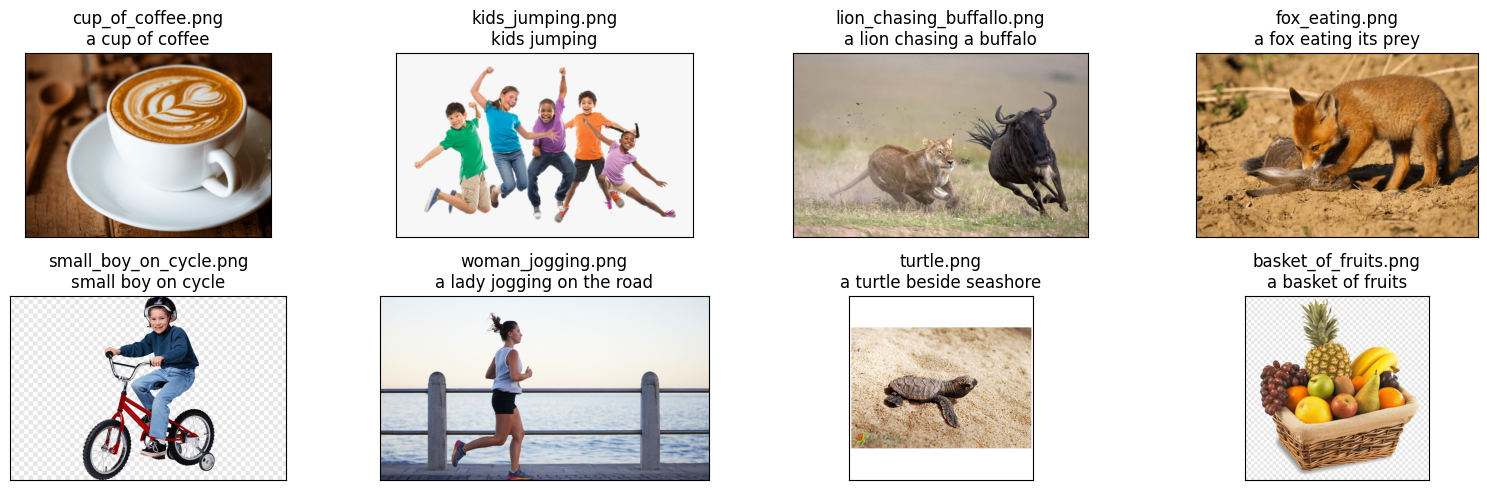

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))
image_data =  'image_captioning'
for filename in [filename for filename in os.listdir(image_data) if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')) or filename.endswith(".jpeg")]:
    name = os.path.splitext(filename)[0]
    #print(name)
    if name not in descriptions:
        continue
    #print("1")
    image = Image.open(os.path.join(image_data, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [ ]:
texts

['a cup of coffee',
 'kids jumping',
 'a lion chasing a buffalo',
 'a fox eating its prey',
 'small boy on cycle',
 'a lady jogging on the road',
 'a turtle beside seashore',
 'a basket of fruits']

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [ ]:
for i in image_input:
  print(i.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

Calculating cosine similarity
We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

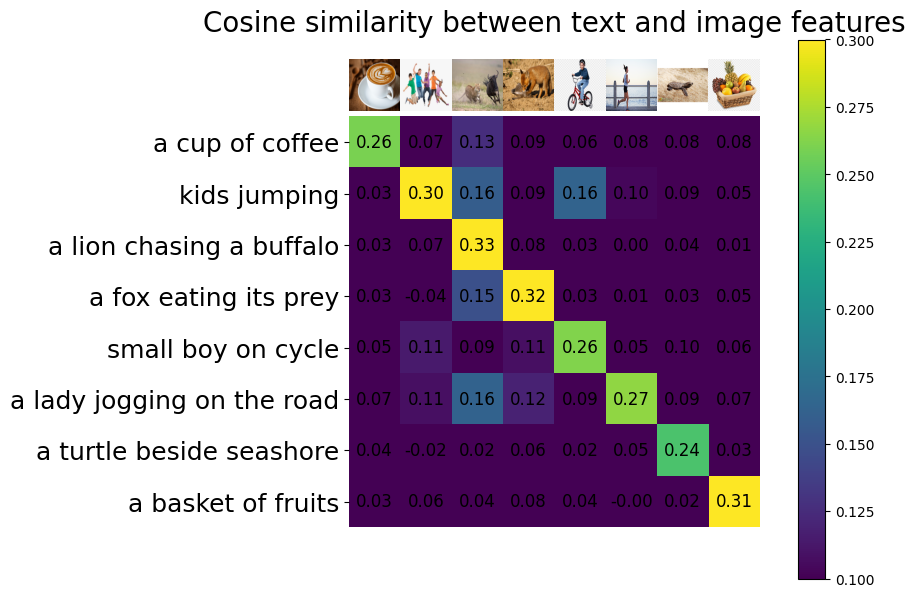

In [ ]:
count = len(descriptions)

plt.figure(figsize=(10, 7))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)